![alt](https://research.utm.my/wp-content/uploads/sites/26/2022/06/logo-300x122.png)
# Center for Artificial Intelligence and Robotics
#### Universiti Teknologi Malaysia


### CNN Classification

*Author: Dr. Ibrahim, Azzam, Thaqif & Syahmi*

**MNIST Dataset**

**Import Package**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset, random_split


**Set Parameter & Download Dataset**

In [4]:
# Parameters
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

# Define the data transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy array to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the dataset
])

# Load the data
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader objects
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Example of how to access the data
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape, target.shape)  # Example output: torch.Size([128, 1, 28, 28]) torch.Size([128])
    break

# input_shape variable
input_shape = (1, img_rows, img_cols)

torch.Size([128, 1, 28, 28]) torch.Size([128])


**Normalize Dataset**


In [5]:
# Example of how to access the data
for data, target in train_loader:
    print(f'Batch data shape: {data.shape}')  # Example output: torch.Size([128, 1, 28, 28])
    print(f'Batch target shape: {target.shape}')  # Example output: torch.Size([128])
    break

# Print dataset shapes
print(f'x_train shape: {train_dataset.data.shape}')
print(f'{len(train_dataset)} train samples')
print(f'{len(test_dataset)} test samples')




Batch data shape: torch.Size([128, 1, 28, 28])
Batch target shape: torch.Size([128])
x_train shape: torch.Size([60000, 28, 28])
60000 train samples
10000 test samples


**Create CNN Model**

In [6]:
# Define the neural network architecture
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Adjust the size according to your input dimensions
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)  # No softmax here
        return x

# Initialize the model, loss function, and optimizer
model = ConvNet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


**Compile Model and Train Model**

In [7]:
from tqdm import tqdm

# Training the model
num_epochs = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap train_loader with tqdm for progress bar
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    # Compute average loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Save the metrics
torch.save({
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies
}, 'model_metrics.pth')


Epoch 1/12: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]


Epoch [1/12], Train Loss: 0.2110, Train Accuracy: 93.61%, Test Loss: 0.0493, Test Accuracy: 98.29%


Epoch 2/12: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]


Epoch [2/12], Train Loss: 0.0816, Train Accuracy: 97.58%, Test Loss: 0.0371, Test Accuracy: 98.79%


Epoch 3/12: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


Epoch [3/12], Train Loss: 0.0610, Train Accuracy: 98.12%, Test Loss: 0.0381, Test Accuracy: 98.87%


Epoch 4/12: 100%|██████████| 469/469 [00:52<00:00,  8.90it/s]


Epoch [4/12], Train Loss: 0.0508, Train Accuracy: 98.46%, Test Loss: 0.0324, Test Accuracy: 99.01%


Epoch 5/12: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]


Epoch [5/12], Train Loss: 0.0444, Train Accuracy: 98.64%, Test Loss: 0.0354, Test Accuracy: 98.93%


Epoch 6/12: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch [6/12], Train Loss: 0.0382, Train Accuracy: 98.79%, Test Loss: 0.0314, Test Accuracy: 99.08%


Epoch 7/12: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch [7/12], Train Loss: 0.0342, Train Accuracy: 98.88%, Test Loss: 0.0298, Test Accuracy: 99.02%


Epoch 8/12: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s]


Epoch [8/12], Train Loss: 0.0302, Train Accuracy: 99.04%, Test Loss: 0.0297, Test Accuracy: 99.12%


Epoch 9/12: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]


Epoch [9/12], Train Loss: 0.0298, Train Accuracy: 99.06%, Test Loss: 0.0265, Test Accuracy: 99.25%


Epoch 10/12: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch [10/12], Train Loss: 0.0258, Train Accuracy: 99.12%, Test Loss: 0.0324, Test Accuracy: 99.14%


Epoch 11/12: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch [11/12], Train Loss: 0.0238, Train Accuracy: 99.23%, Test Loss: 0.0322, Test Accuracy: 99.15%


Epoch 12/12: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]


Epoch [12/12], Train Loss: 0.0221, Train Accuracy: 99.29%, Test Loss: 0.0303, Test Accuracy: 99.12%


**Plot Test Dataset**

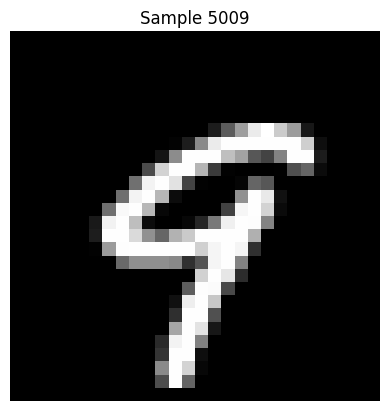

In [13]:
#print(x_test[500].shape)

sample_index = 5009
batch_size = test_loader.batch_size

batch_index = sample_index // batch_size
sample_index_in_batch = sample_index % batch_size

for i, (data, target) in enumerate(test_loader):
    if i == batch_index:
        # Get the data tensor for the sample at index 500
        sample_data = data[sample_index_in_batch].squeeze().cpu().numpy()
        break
else:
    print(f"Sample {sample_index} does not exist in the test dataset.")


# Show the test image
# Plot the data tensor for the sample at index 500
plt.imshow(sample_data, cmap='gray')
plt.title(f'Sample {sample_index}')
plt.axis('off')
plt.show()

**Predict, Save and Load Model**
# Answer Question 1 - Prediction

In [16]:
#data = x_test[500]
#dt = np.reshape(data, [1, 28, 28, 1])

# Predict dt from the trained model


# Load the image and preprocess it
sample_data_tensor = torch.tensor(sample_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    ##Answer Here##
    outputs = model(sample_data_tensor)
    predicted_probs = torch.softmax(outputs, dim=1)

# Convert the predicted probabilities tensor to a numpy array
predicted_probs_np = predicted_probs.cpu().numpy()
predicted_probs_np = np.round(predicted_probs_np, 3)


# Get the predicted class (index with the highest probability)
predicted_class = np.argmax(predicted_probs_np)
print("Predicted class probabilities:", predicted_probs_np)
print("Predicted class:", predicted_class)

Predicted class probabilities: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Predicted class: 9


# Answer Question 2 - Save Model


In [ ]:
# Save the model's state dictionary to your Google Drive folder

# Specify the file path
model_path = '/home/jupyter-thaqif/cnn/modelcnn.pt'

# Save the state dictionary
torch.save(model.state_dict(), model_path)

In [ ]:
import os

# List files in the directory
directory_path = '/home/jupyter-thaqif/cnn/'
files = os.listdir(directory_path)
print("Files in directory:", files)


# Answer Question 3 - Load Model




In [ ]:
import torch

# Load the model from your Google Drive folder
model_path = '/home/jupyter-thaqif/cnn/modelcnn.pt'

# Initialize your model instance
loaded_model = ConvNet()

# Load the state dictionary from the file
state_dict = torch.load(model_path)

# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device
loaded_model = loaded_model.to(device)

# Move the input tensor to the selected device
sample_data_tensor = sample_data_tensor.to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Perform inference
with torch.no_grad():
    outputs1 = loaded_model(sample_data_tensor)
    predicted_probs1 = torch.softmax(outputs1, dim=1)

# Convert the predicted probabilities tensor to a numpy array
predicted_probs_np1 = predicted_probs1.cpu().numpy()
predicted_probs_np1 = np.round(predicted_probs_np1, 3)

# Get the predicted class (index with the highest probability)
predicted_class1 = np.argmax(predicted_probs_np1)
print("Predicted class probabilities:", predicted_probs_np1)
print("Predicted class:", predicted_class1)
